In [1]:
cd ..

/Users/n.barsukov/PycharmProjects/toxic-comments-detector


In [2]:
import sys
import tensorflow as tf
import numpy as np

# local (this repo) imports
from dev import (
    load_cleaned_russian_text_data,
    get_class_weights,
    get_initial_output_bias,
    evaluate_model,
    SEED
)
from wordEmbeddingsLayers import create_wiki40_russian_embedding_layer

tf.random.set_seed(SEED)

print('Python version:', sys.version)
print('Tensorflow version:', tf.__version__)

Python version: 3.8.9 (default, Apr  3 2021, 01:50:09) 
[Clang 12.0.0 (clang-1200.0.32.29)]
Tensorflow version: 2.4.1


# Build RNN model

In [3]:
X_train, X_test, y_train, y_test = load_cleaned_russian_text_data()

In [4]:
from tensorflow.keras import layers, losses

negative_class_amount, pos_class_amount = np.bincount(y_train)

initial_output_bias = tf.keras.initializers.Constant(
    get_initial_output_bias(pos_class_amount, negative_class_amount)
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=2,
    verbose=1,
    restore_best_weights=False
)

model = tf.keras.Sequential([
    layers.Input(shape=[], dtype=tf.string),
    create_wiki40_russian_embedding_layer(),
    
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    layers.Dropout(rate=0.2, seed=SEED),
    
    tf.keras.layers.Dense(64, activation='relu'),
    layers.Dropout(rate=0.2, seed=SEED),
    layers.Dense(units=1, bias_initializer=initial_output_bias),
    layers.Activation('sigmoid') # то есть в конце мы выдаем уже вероятности
])

model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), # from_logits=False, т.к. на выходе layers.Activation('sigmoid')
    optimizer='adam',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [5]:
epochs = 10
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=epochs,
    batch_size=2**9,
    validation_split=0.2, # сколько от тестовой выборки отрезать под валидационную
    callbacks=[early_stopping],
    class_weight=get_class_weights(pos_class_amount, negative_class_amount),
)

Epoch 1/10
19/19 [==============================] - 114s 6s/step - loss: 0.7505 - binary_accuracy: 0.5613 - recall: 0.4861 - precision: 0.3748 - val_loss: 0.5498 - val_binary_accuracy: 0.7554 - val_recall: 0.5742 - val_precision: 0.6504
Epoch 2/10
19/19 [==============================] - 120s 7s/step - loss: 0.5486 - binary_accuracy: 0.7563 - recall: 0.6448 - precision: 0.6399 - val_loss: 0.4066 - val_binary_accuracy: 0.8248 - val_recall: 0.6641 - val_precision: 0.7774
Epoch 3/10
19/19 [==============================] - 120s 6s/step - loss: 0.4198 - binary_accuracy: 0.8315 - recall: 0.7704 - precision: 0.7401 - val_loss: 0.6206 - val_binary_accuracy: 0.7316 - val_recall: 0.9505 - val_precision: 0.5568
Epoch 4/10
19/19 [==============================] - 121s 6s/step - loss: 0.4036 - binary_accuracy: 0.8236 - recall: 0.8642 - precision: 0.6995 - val_loss: 0.3447 - val_binary_accuracy: 0.8612 - val_recall: 0.7760 - val_precision: 0.8011
Epoch 5/10
19/19 [==============================] - 

# Model evaluation

Accuracy: 89.32%
Recall: 79.87%
Precision: 86.79%
F1-score: 83.19% 



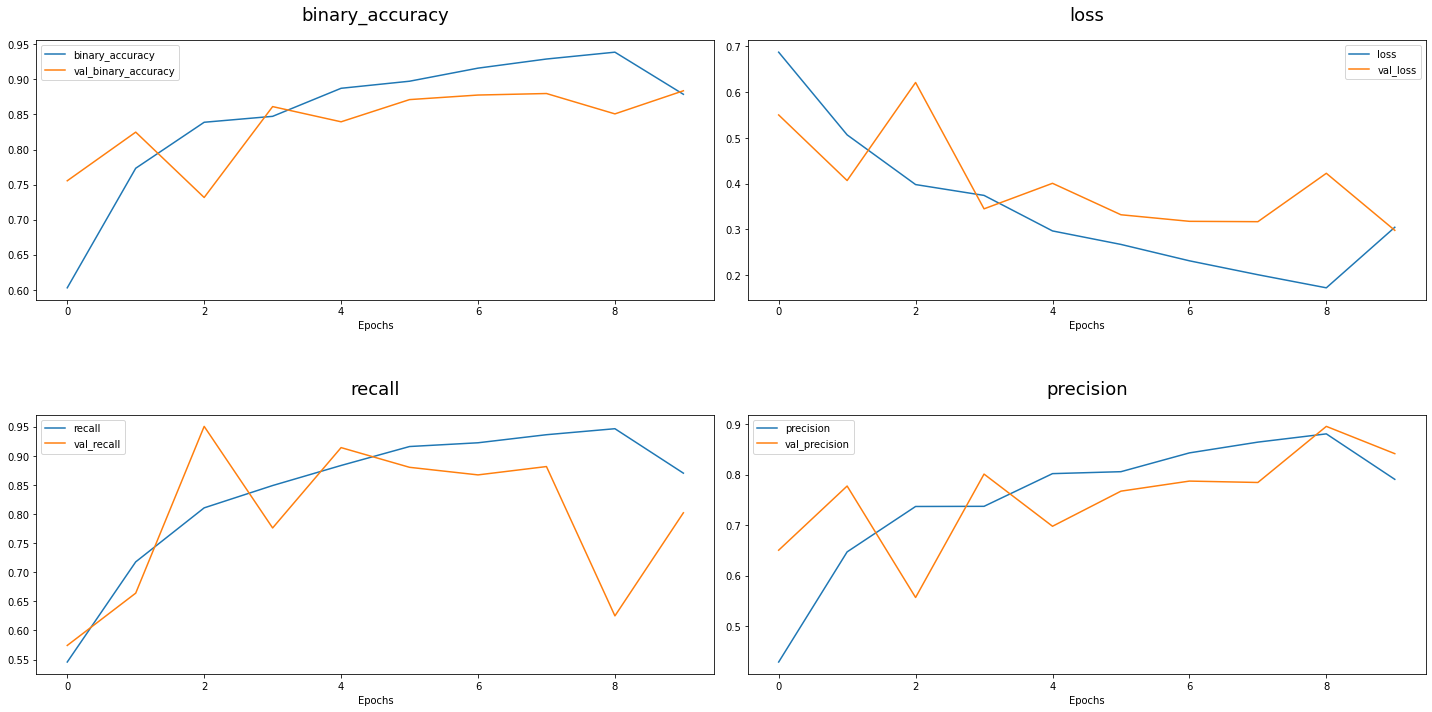

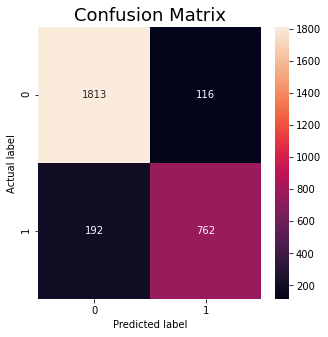

In [6]:
y_test_pred = (model.predict(X_test).flatten() > 0.5) * 1

evaluate_model(y_test, y_test_pred, history)